# Establish vorticity-luminosity scaling law

Works with jupyterlab3 on ppmstar.org

## (1) Initialization

In [1]:
%pylab ipympl
import os,sys
from multiprocessing import Pool
from tqdm import tqdm

sys.path.insert(0,'/home/user/user/niagara_scratch_sblouin/PyPPM')
from ppmpy import ppm

# set cycling combination of color-blind labels, glyphs, styles
lll= 2*['-', '--', ':', '-.']
markers = ['X','h','<','>','s','^','d','X','p']
random.shuffle(lll)
CB_color_cycle = ['#4daf4a', '#a65628', '#984ea3',
                  '#ff7f00', '#f781bf', '#377eb8',
                  '#999999', '#e41a1c', '#dede00']
rc('axes', prop_cycle=(cycler('color', CB_color_cycle[0:8]) + cycler('marker',markers[0:8])+cycler('linestyle',lll)))
import collections
hydro = collections.namedtuple('hydro', ['moms','rprof'])

# turn off matplotlib messages
logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

Matplotlib is building the font cache; this may take a moment.


Populating the interactive namespace from numpy and matplotlib


In [2]:
# the list of variables that are stored within the momsdata cube.
var_list = ['xc','ux','uy','uz','|ut|','|ur|','|w|','P','rho','fv']

## (2) Load rprofs

In [3]:
data_dir = '/home/user/user/niagara_scratch_fherwig/'
minner_setup = 585478.8819
runs = ['X14','X15','X16','X17','X18','X21']
heating = np.array([1000,100,10,10000,3162,316.2])
run_dir = ['X14-1000xL-1000xK-heating-768-mc2400-rin40','X15-100xL-100xK-heating-768-mc2400-rin40',
          'X16-10xL-10xK-heating-768-mc2400-rin40','X17-1e4xL-1e4xK-heating-768-mc2400-rin40',
          'X18-3162xL-3162xK-heating-768-mc2400-rin40',
          'X21-316xL-316xK-heating-768-mc2400-rin40']

In [4]:
rprof = {}
rprofbq = {}
for i,run in enumerate(runs):
    rprof_dir = os.path.join(data_dir,run_dir[i],'prfs')
    rprof[run] = ppm.RprofSet(rprof_dir)
    rprofbq[run] = ppm.RprofSet(rprof_dir, bqav=True, var_list=var_list)

420 rprof files found in '/home/user/user/niagara_scratch_fherwig/X14-1000xL-1000xK-heating-768-mc2400-rin40/prfs/.
Dump numbers range from 0 to 419.
420 rprof files found in '/home/user/user/niagara_scratch_fherwig/X14-1000xL-1000xK-heating-768-mc2400-rin40/prfs/frombqavs/.
Dump numbers range from 0 to 419.
724 rprof files found in '/home/user/user/niagara_scratch_fherwig/X15-100xL-100xK-heating-768-mc2400-rin40/prfs/.
Dump numbers range from 0 to 723.
721 rprof files found in '/home/user/user/niagara_scratch_fherwig/X15-100xL-100xK-heating-768-mc2400-rin40/prfs/frombqavs/.
Dump numbers range from 0 to 720.
580 rprof files found in '/home/user/user/niagara_scratch_fherwig/X16-10xL-10xK-heating-768-mc2400-rin40/prfs/.
Dump numbers range from 0 to 579.
521 rprof files found in '/home/user/user/niagara_scratch_fherwig/X16-10xL-10xK-heating-768-mc2400-rin40/prfs/frombqavs/.
Dump numbers range from 0 to 520.
309 rprof files found in '/home/user/user/niagara_scratch_fherwig/X17-1e4xL-1e4xK-

In [14]:
dumps_range = {}
for i,run in enumerate(runs):
    dumps_range[i] = arange(max(rprofbq[run].get_dumps())-100, max(rprofbq[run].get_dumps()),2)
    if run=='X17': # this is to avoid selecting dumps where the CB has moved too much inward
        dumps_range[i] = arange(100,120,1)

## (3) Plot r profiles

X14 0.00023296723388333335
X15 9.745978912895834e-05
X16 4.0646352784791665e-05
X17 0.0006156612600781249
X18 0.00037853109554583333
X21 0.00015237876838333333


Text(0.5, 1.0, 'Vorticity profiles - RGB bump')

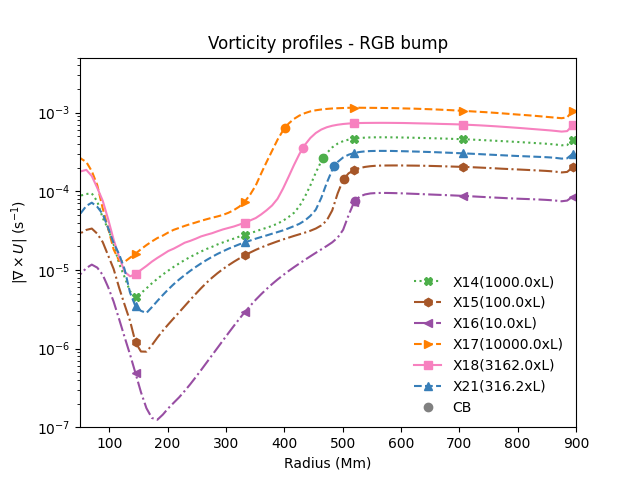

In [16]:
cvz_position = []
close(1);figure(1)
for i,run in enumerate(runs):
    dumps = dumps_range[i]
    for j,dump in enumerate(dumps):
        w_momst, r_moms = rprofbq[run].get('|w|',dump), rprofbq[run].get('xcmax',dump)
        if j==0:
            w_moms = w_momst
        else:
            w_moms += w_momst
    w_moms = w_moms/len(dumps)
    print(run,mean(w_moms))
    semilogy(r_moms, w_moms, label=run+'('+str(heating[i])+'xL)', markevery=20, color=CB_color_cycle[i])
    cp = rprof[run].bound_rad(cycles=dumps,r_min=200,r_max=800,var='|Ut|',criterion='max_grad') 
    # max_grad(Ut) instead of min_grad(Ut) because transition is going inward instead of outward
    cp = mean(cp)
    cvz_position.append(cp)
    plot(cp, np.interp(cp,r_moms[::-1],w_moms[::-1]), 'o', color=CB_color_cycle[i])
plot([0],[0],'o',color='grey',label='CB')
legend(frameon=False)
ylim(1e-7,5e-3)
xlim(50,900)
xlabel('Radius (Mm)')
ylabel(r'$| \nabla \times U |$ (s$^{-1}$)')
title('Vorticity profiles - RGB bump')

## (4) Scaling law in the convection zone

In [17]:
matplotlib.rcParams.update({'font.size': 12})

In [18]:
rbelow_min = 700-100
rbelow_max = 700+100
vort_result = []
for i,run in enumerate(runs):
    j = 0
    wm = 0
    dumpst = dumps_range[i]
    for dump in dumpst:
        j += 1
        w_moms, r_moms = rprofbq[run].get('|w|',dump), rprofbq[run].get('xcmax',dump)
        wm += mean(w_moms[(r_moms>rbelow_min)&(r_moms<rbelow_max)])
    vort_result.append(wm/j)

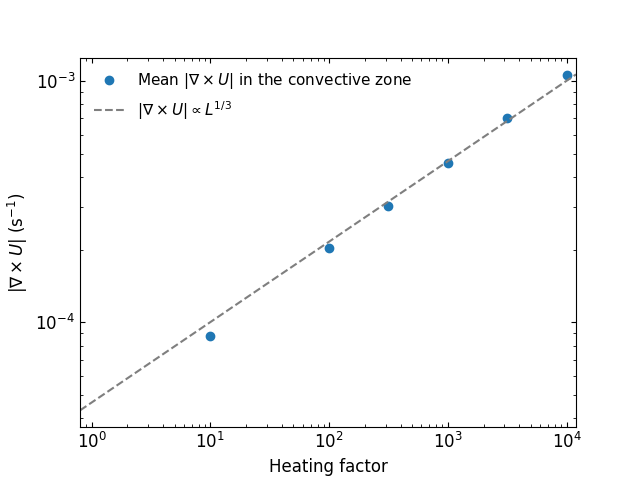

In [21]:
close(2);figure(2)
j=0
xmin, xmax = .8,12e3
exponent = 1/3
loglog(heating, vort_result, ls='None', color='tab:blue', marker='o',label=r'Mean $| \nabla \times U |$ in the convective zone')
heating_vec = np.linspace(xmin, xmax, 100)
factor = np.max(vort_result)/(np.max(heating)**exponent)
vort_vec = factor*heating_vec**(exponent)*0.95
plot(heating_vec, vort_vec, '--', color='tab:grey', label=r'$| \nabla \times U | \propto L^{1/3}$')
legend(frameon=False, fontsize=11)
xlabel('Heating factor')
ylabel(r'$| \nabla \times U |$ (s$^{-1}$)')
xlim(xmin, xmax)
#title('Convection zone - RGB bump')
ax = plt.gca()
ax.tick_params(axis='both',direction='in',which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
savefig('scaling_cvz.pdf', bbox_inches='tight')

## (5) Scaling law in the envelope

Scaling law of the vorticity at fixed distance below convection zone. Fixed radius would make no sense since the convective zone does not have the same extent when heating is changed.

The average is taken between `rbelow_min` and `rbelow_max`, and between `dump_min` and `dump_max`.

In [23]:
rbelow_min = 200-10
rbelow_max = 200+10
vort_result = []
for i,run in enumerate(runs):
    j = 0
    wm = 0
    dumpst = dumps_range[i]
    for dump in dumpst:
        j += 1
        w_moms, r_moms = rprofbq[run].get('|w|',dump), rprofbq[run].get('xcmax',dump)
        wm += mean(w_moms[(r_moms>(cvz_position[i]-rbelow_max))&(r_moms<(cvz_position[i]-rbelow_min))])
    vort_result.append(wm/j)

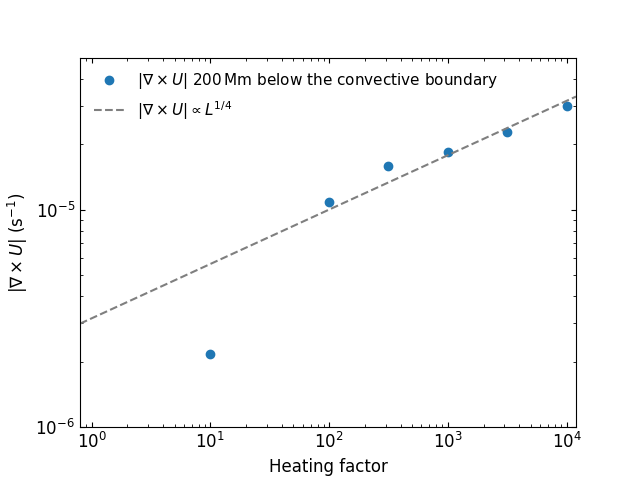

In [29]:
close(3);figure(3)
j=0
xmin, xmax = .8,12000

loglog(heating, vort_result, ls='None', color='tab:blue', marker='o',label=r'$| \nabla \times U |$ 200$\,$Mm below the convective boundary')
heating_vec = np.linspace(xmin, xmax, 100)
#
exponent = 1/4
factor = np.max(vort_result)/(np.max(heating)**exponent)
vort_vec = 1.06*factor*heating_vec**(exponent)
plot(heating_vec, vort_vec, '--', color='tab:grey', label=r'$| \nabla \times U | \propto L^{1/4}$')
#
legend(frameon=False,loc=2,fontsize=11)
xlabel('Heating factor')
ylabel(r'$| \nabla \times U |$ (s$^{-1}$)')
xlim(xmin, xmax)
ylim(1e-6,.5e-4)
ax = plt.gca()
ax.tick_params(axis='both',direction='in',which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
savefig('scaling_rad.pdf', bbox_inches='tight')
#title('Radiative envelope - RGB bump')